# Analysis and Model Creation Notebook

## Imports: libraries and dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df = pd.read_csv('../dataset/KAG_energydata_complete.csv')

## Preliminary Exploratory Data Analysis (EDA)

Check for Missing values

In [3]:
missing_values = df.isnull().sum()
print(missing_values)

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


Understand data types

In [4]:
print(df.dtypes)

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object


## Modifying the date type

Change date type to date

In [5]:
df['date'] = pd.to_datetime(df['date'])

Set date as index, to make it easier to work with time series

In [6]:
df.set_index('date', inplace=True)

## Descriptive statistics

In [7]:
#The stats for the whole dataset
summary_stats = df.describe()
print(summary_stats)

         Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875     21.686571     40.259739     20.341219   
std      102.524891      7.935988      1.606066      3.979299      2.192974   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max     1080.000000     70.000000     26.260000     63.360000     29.856667   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.420420     22.267611     39.242500     20.855335     39.026904   
std        4.069813      2.006111      3.254576    

Plot the distributions of the Appliances and Lights variables

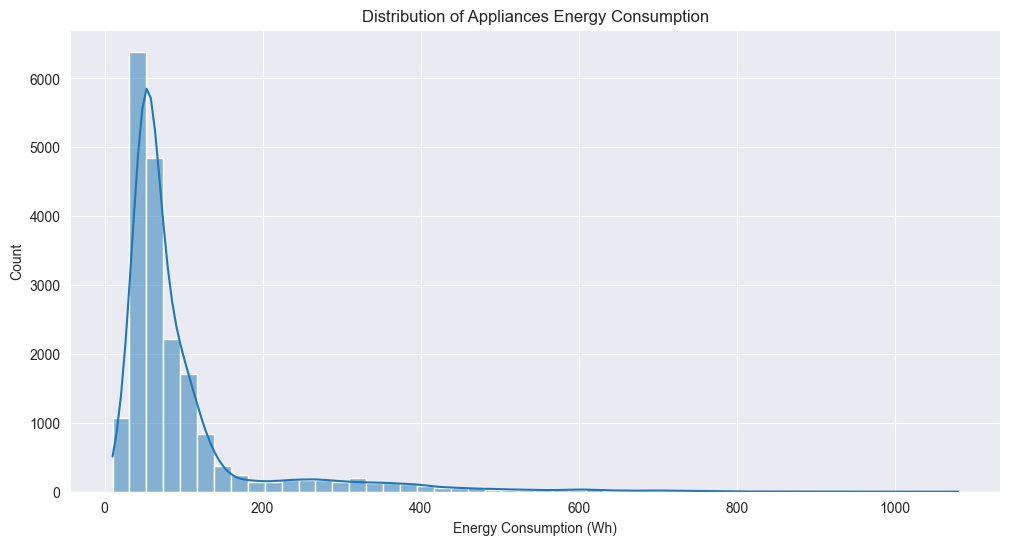

In [8]:
plt.figure(figsize=(12,6))
sns.histplot(df['Appliances'], bins=50, kde=True)
plt.title('Distribution of Appliances Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.show()

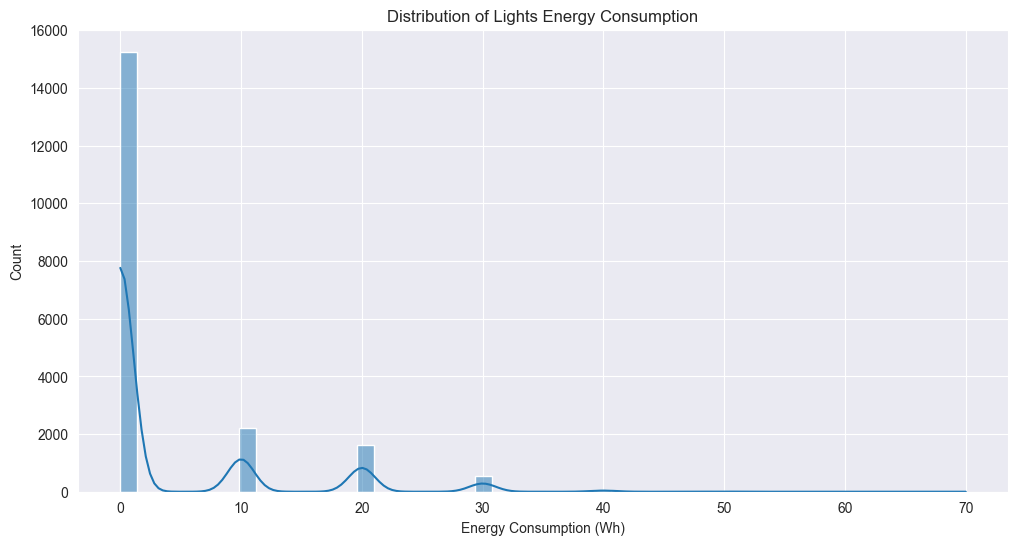

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['lights'], bins=50, kde=True)
plt.title('Distribution of Lights Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.show()

## Feature Engineering

Add the hour, day_of_week and month to the dataset as individual columns for Seasonal trend analysis

In [10]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

Observe how many data entries in the lights feature are 0

In [11]:
not_null_lights = (df['lights'] == 0).sum()
print(not_null_lights)

15252


Drop the lights feature: since there are 15k elements with value 0, it doesn't hold much relevance

In [12]:
df.drop(columns='lights', inplace=True)

In [13]:
print(df.columns)

Index(['Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4',
       'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',
       'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'hour', 'day_of_week', 'month'],
      dtype='object')


## Time Series Analysis

Plot the Energy Consumption Over Time

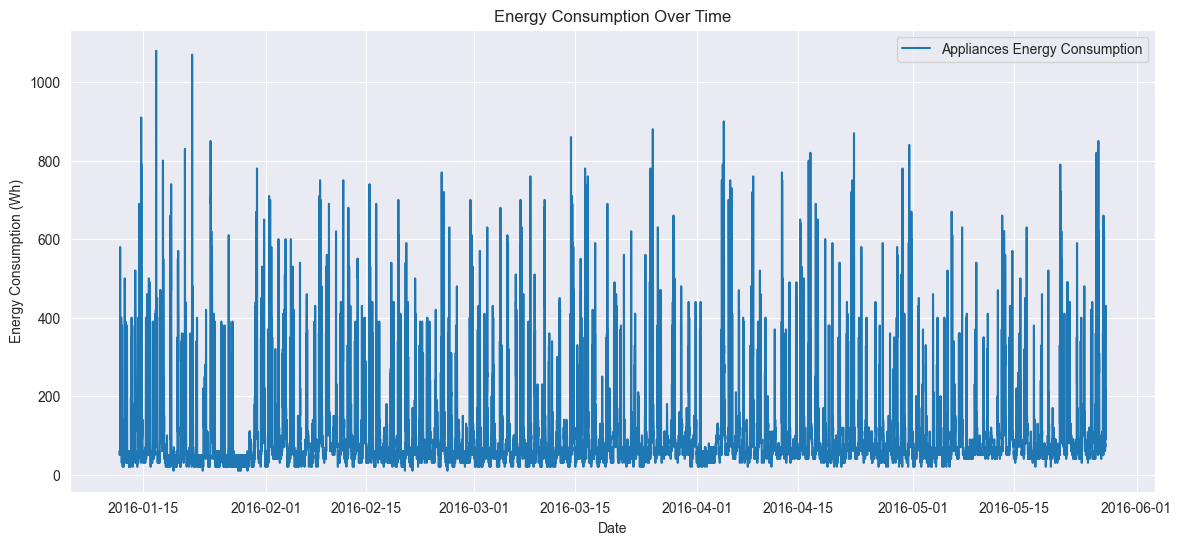

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Appliances'], label= 'Appliances Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.grid(True)
plt.show()

Plot for hourly Energy Consumption: through the median value we can see a curve that tops at hour 18

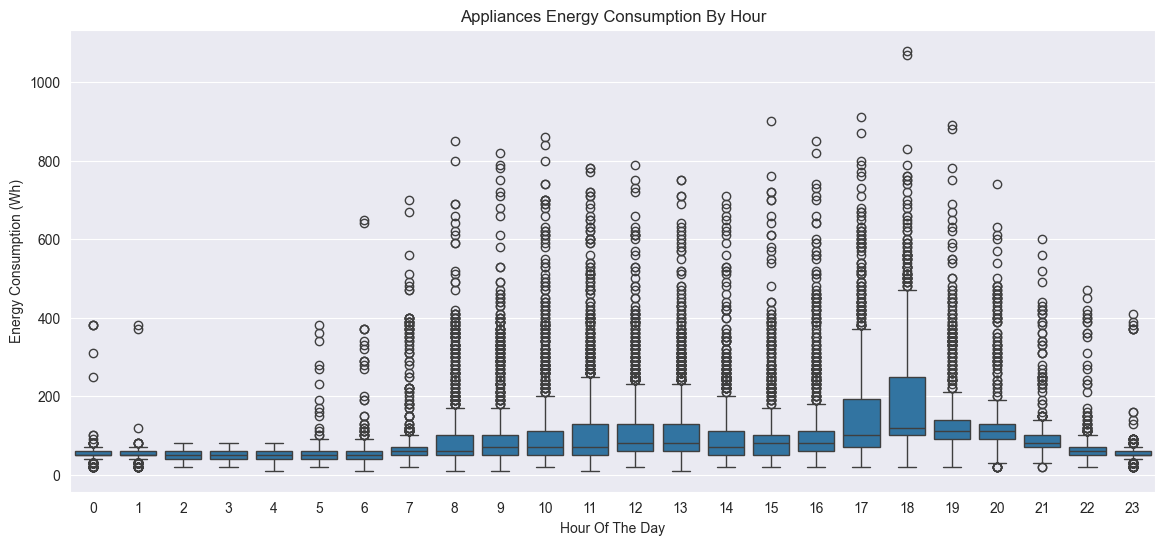

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='hour', y='Appliances', data=df)
plt.title('Appliances Energy Consumption By Hour')
plt.xlabel('Hour Of The Day')
plt.ylabel('Energy Consumption (Wh)')
plt.show()

Plot for daily Energy Consumption: day 2 and 5 have a bigger median consumptions, the other are roughly on the same level

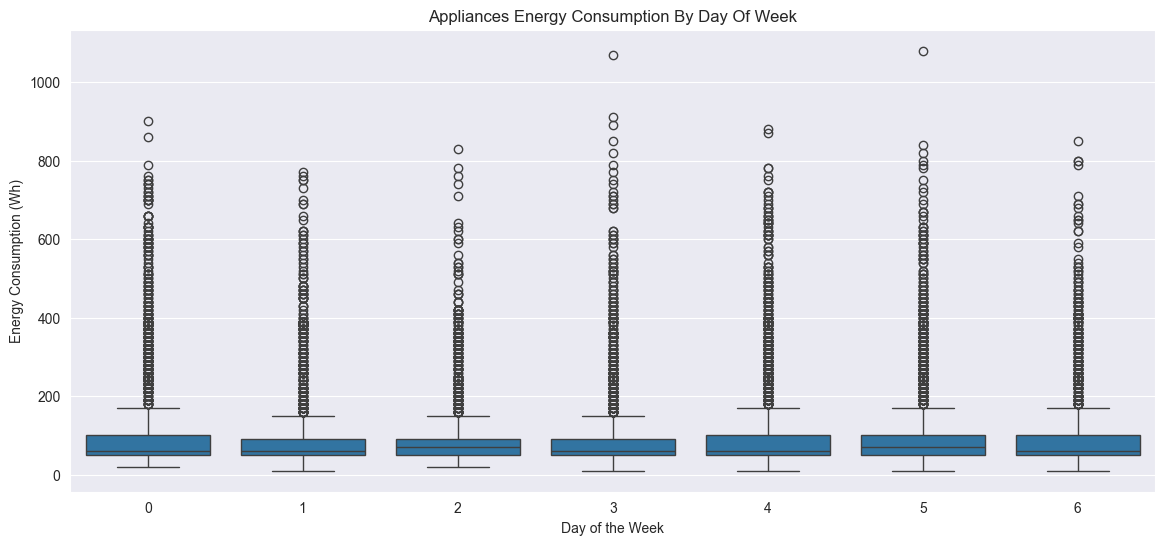

In [16]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='day_of_week', y='Appliances', data=df)
plt.title('Appliances Energy Consumption By Day Of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Energy Consumption (Wh)')
plt.show()

Plot for Monthly Energy Consumpion: the months don't have any particular remark, the median value is more or less the same

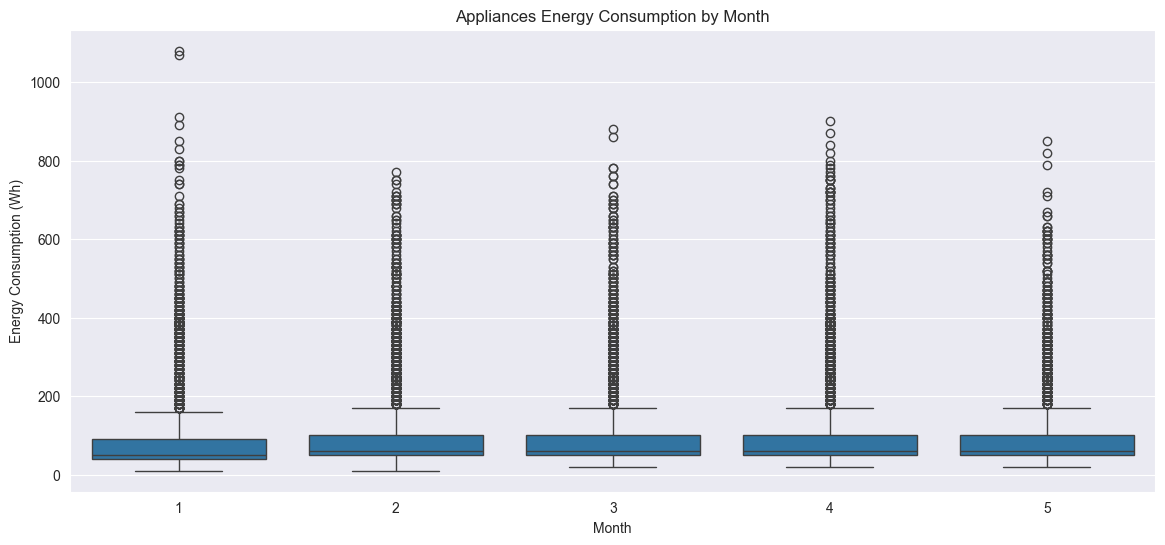

In [17]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='month', y='Appliances', data=df)
plt.title('Appliances Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (Wh)')
plt.show()

## Correlation Analysis

Correlation Matrix: as we can see the Appliances feature has no major correlation, the biggest one is with the hour of the day at 0.22

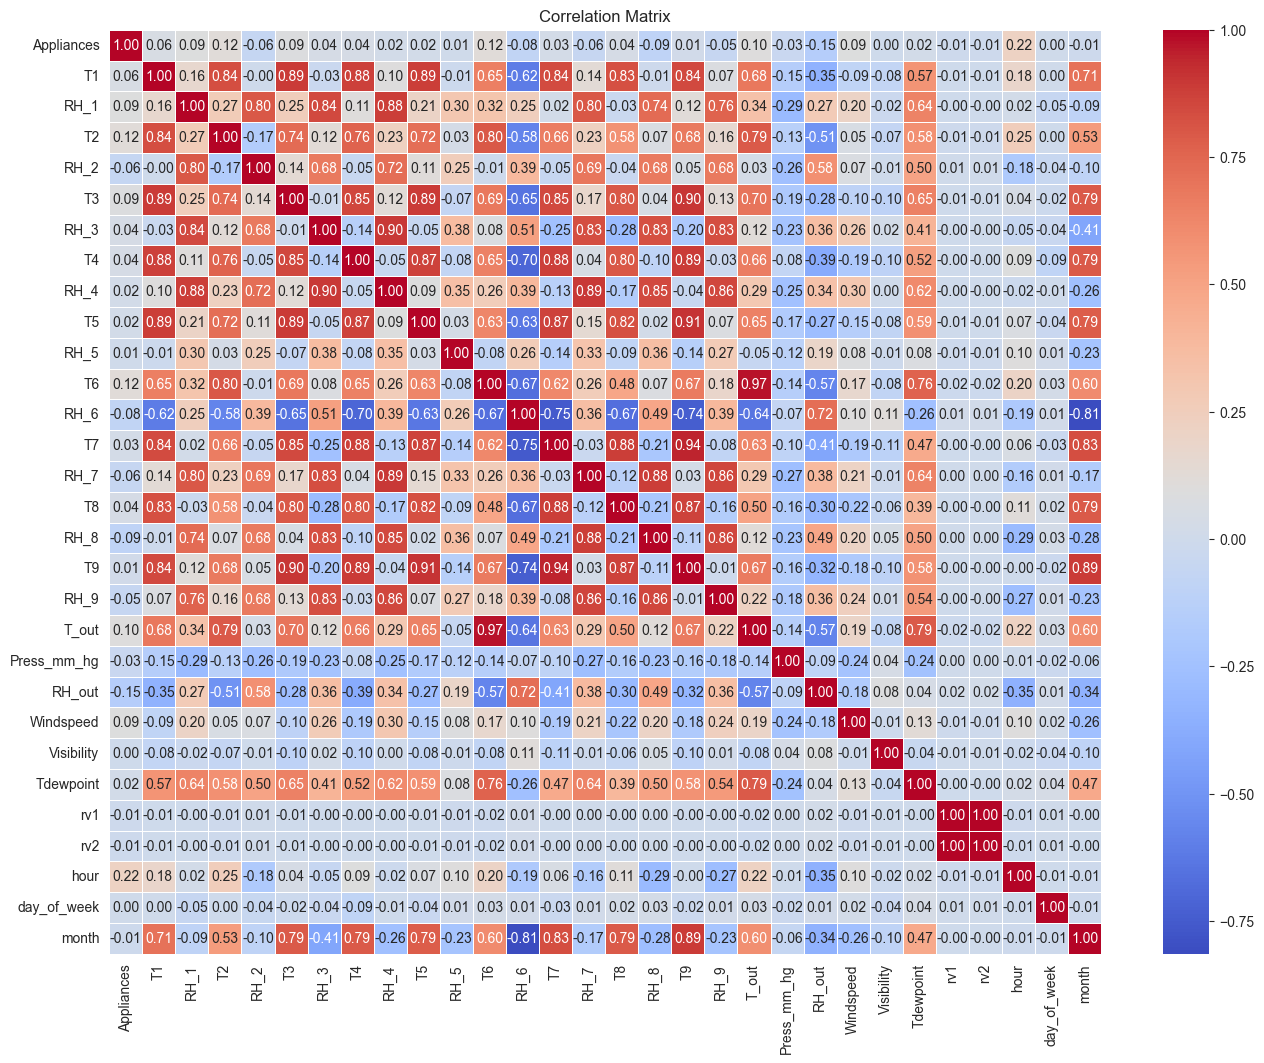

In [18]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

Scatter Plot for Temperature: between 19 and 24 degrees the mean energy consumption is a tad higher

Text(0.5, 1.0, 'Appliances Energy Consumption vs. T1')

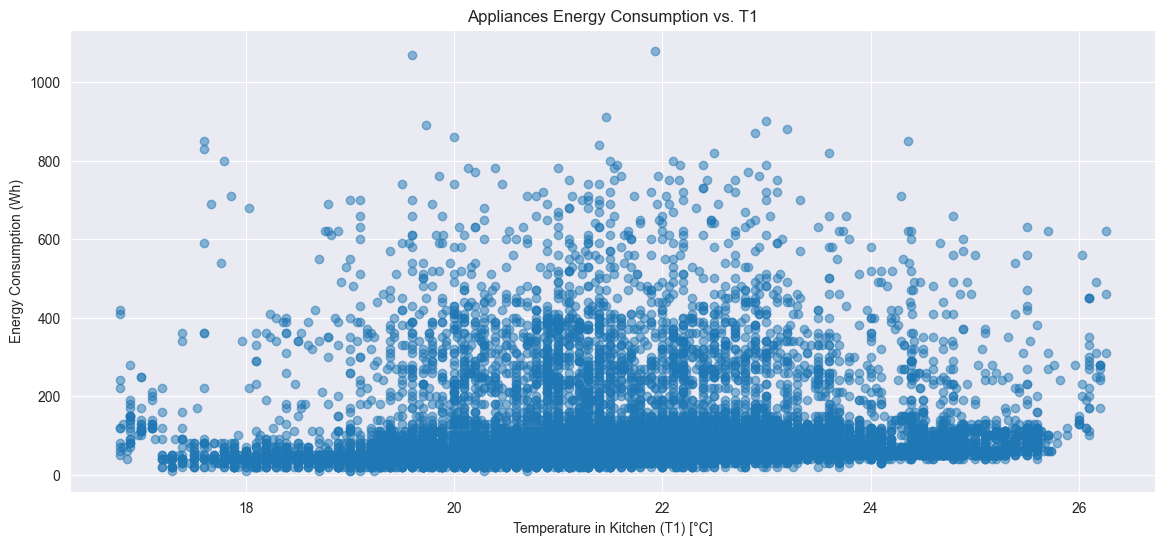

In [19]:
plt.figure(figsize=(14, 6))
plt.scatter(df['T1'], df['Appliances'], alpha=0.5)
plt.xlabel('Temperature in Kitchen (T1) [°C]')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Appliances Energy Consumption vs. T1')

Scatter Plot for Humidity: between 35 and 47 the mean enenrgy consumption is a tad higher

Text(0.5, 1.0, 'Appliances Energy Consumption vs. RH_1')

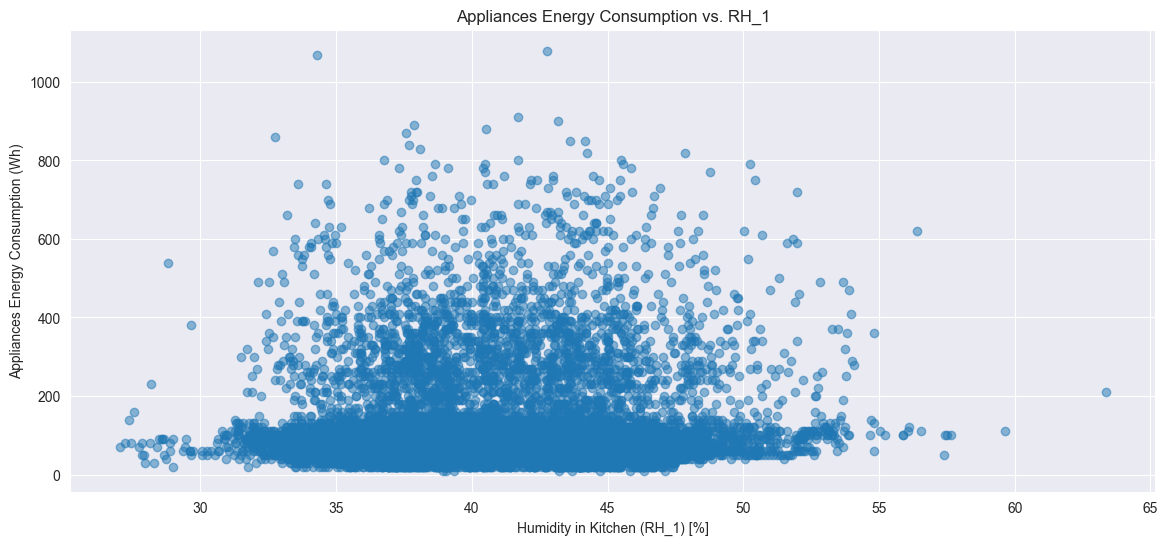

In [20]:
plt.figure(figsize=(14, 6))
plt.scatter(df['RH_1'], df['Appliances'], alpha=0.5)
plt.xlabel('Humidity in Kitchen (RH_1) [%]')
plt.ylabel('Appliances Energy Consumption (Wh)')
plt.title('Appliances Energy Consumption vs. RH_1')

Pair plots of Appliances, temperature and humididty

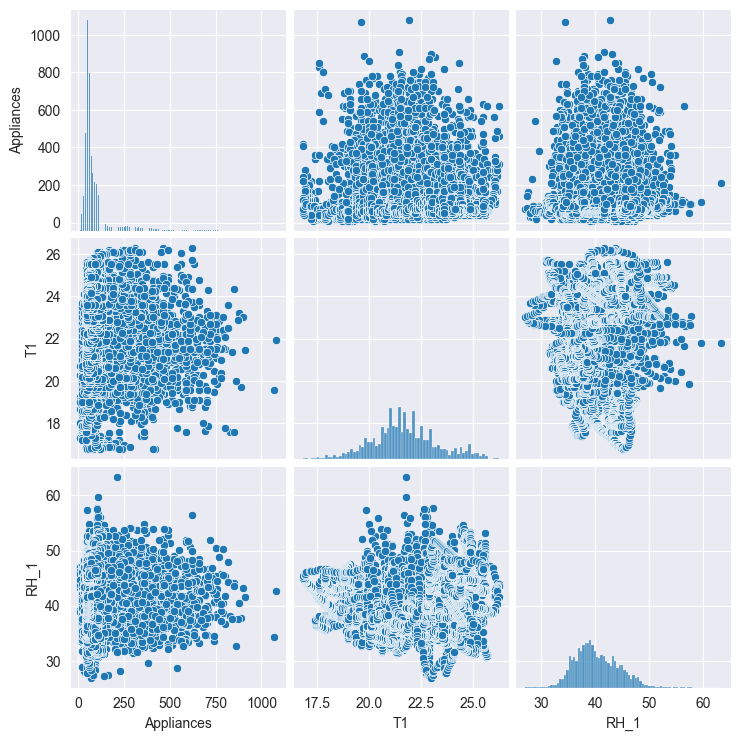

In [21]:
sns.pairplot(df, vars = ['Appliances', 'T1', 'RH_1'])
plt.show()

## Enhanced Feature Engineering

R2 score is 0.648

In [22]:
for lag in range(1, 25):
    df[f'Appliances_lag_{lag}'] = df['Appliances'].shift(lag)
df.dropna(inplace=True)


With rolling windows added, R2 score is 0.748

In [23]:
df['rolling_mean'] = df['Appliances'].rolling(window=24).mean()
df['rolling_std'] = df['Appliances'].rolling(window=24).std()
df.dropna(inplace=True)  # Drop rows with NaN values created by rolling window


## Model Creation

First test with lightgbm

In [24]:
X = df.drop(columns='Appliances')
y = df['Appliances']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

No difference between standard scaler and MinMax scaler

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [28]:
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_round': 100
}


In [29]:
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=3000,
                  valid_sets=[lgb_train, lgb_eval])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8867
[LightGBM] [Info] Number of data points in the train set: 15750, number of used features: 55
[LightGBM] [Info] Start training from score 98.231111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1620]	training's l1: 5.95379	valid_1's l1: 22.9729


In [30]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)


In [31]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

LightGBM MAE: 22.972929515229087
LightGBM MSE: 2453.7793540111775
LightGBM R^2 Score: 0.7488762745876958
